In [31]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from random import randrange
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score


In [32]:
# Settings:
pd.set_option('display.width', 190)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
pd.set_option('max_colwidth', 200)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('default')
np.set_printoptions(threshold = 30, edgeitems = 30, precision = 2, suppress = False)


In [33]:
df_path = "../merged_data/CAPE_BAAFFM_BCI_CCI_CLI_IJC_PMIC_T10Y2Y_T10Y3M_vs_USRESCD_GDP.csv"
features = ['CAPE', "BAAFFM", "BCI", "CCI", "CLI", "IJC", "PMIC", "T10Y2Y", "T10Y3M"]
model_names_classification = ["Logistic Regression", "Penalized SVM", "Random Forest"]
model_names_regression = ["Linear Regression"]
get_classification_models = [lambda: linear_model.LogisticRegression(), lambda: svm.SVC(kernel='linear',\
    class_weight='balanced', probability=True), lambda: RandomForestClassifier()]
get_regression_models = [lambda: linear_model.LinearRegression()]
target_variables_classification = ["USRECD"]
target_variables_regression = ["GDP_rate", "GDP_abs"]
target_variables = target_variables_classification + target_variables_regression


In [34]:
# Read the data and do a little bit of wrangling:
df = pd.read_csv(df_path)
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date", drop=True)
df = df.dropna()


In [52]:
# Split into training and test sets and hold out the test set until the end, so that it remains "unseen".
lag_of_y = 180 # This is the lag in days we introduce to the predictor variable so that we assess 
              # the indicator's ability to predict the target variable this many steps into the future.

df_x = df.shift(lag_of_y, freq="d")[df.columns.difference(target_variables)]
df_y = df[target_variables]
        
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, shuffle=False)


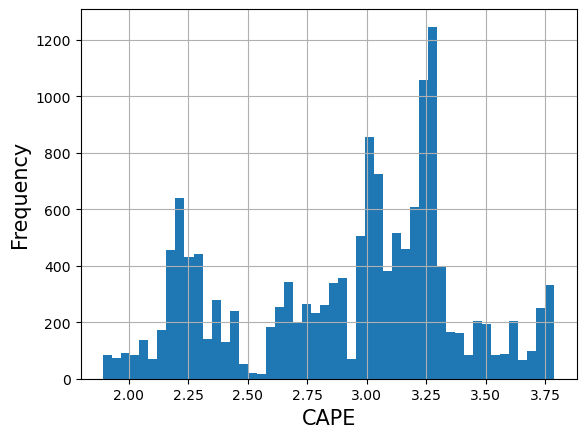

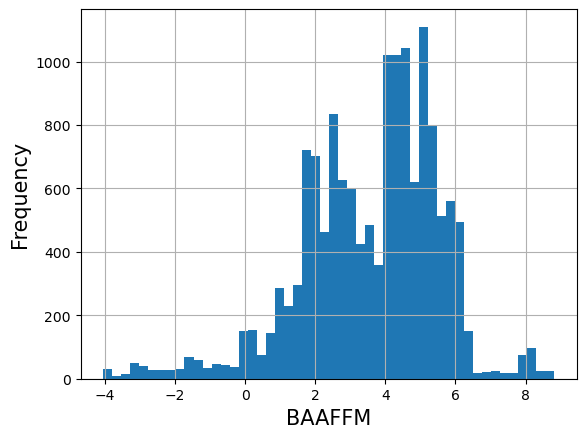

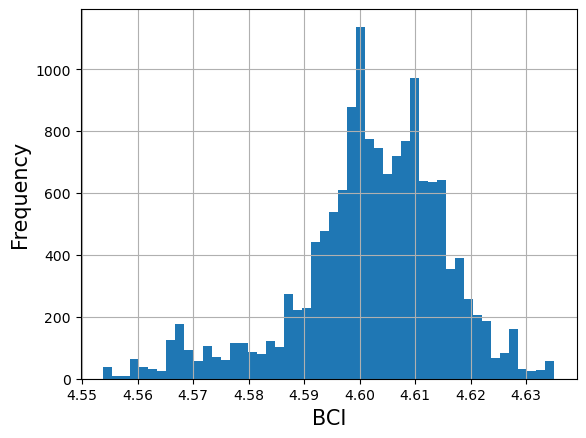

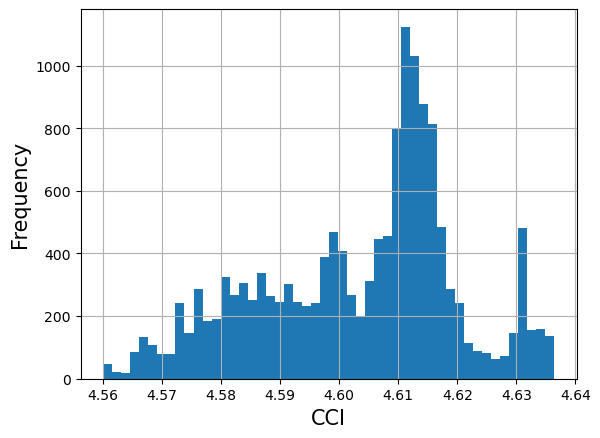

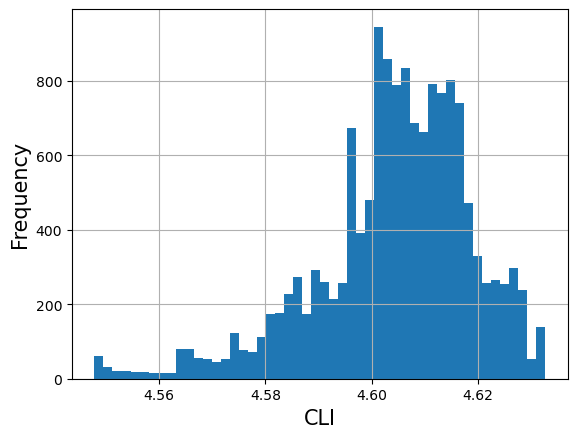

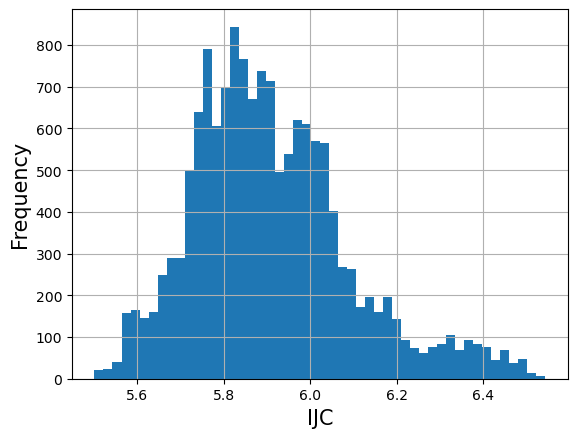

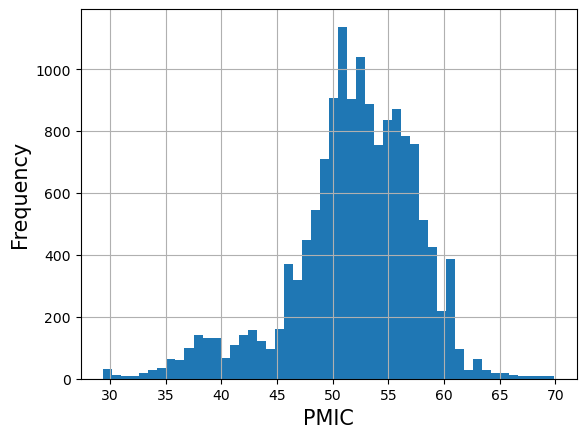

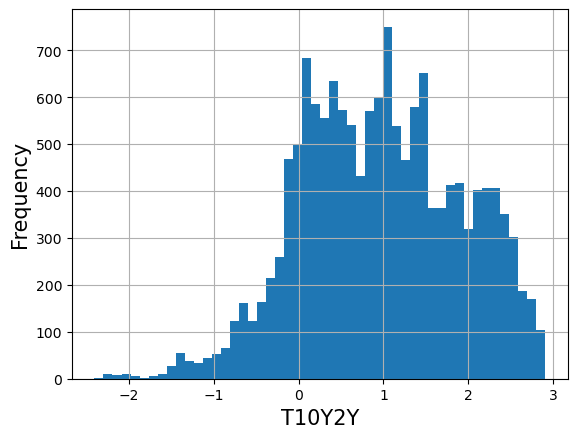

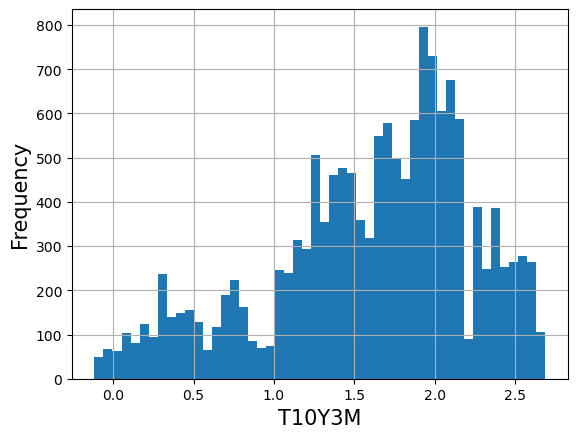

In [53]:
# Histrograms of the features in training set before any scaling
for feature in features:
    plt.figure()
    X_train[feature].hist(bins = 50)
    plt.xlabel(feature,fontsize=15)
    plt.ylabel("Frequency",fontsize=15)
    plt.show()


 ## Validation

In [54]:
# Do a time series cross-validation on the test set by splitting it into k folds and doing a "rolling"
# validation against a validation fold, then averaging out the metrics.
splits = 3 # This is the number of splits/folds in the rolling validation.
tscv = TimeSeriesSplit(n_splits=splits)
pd.options.mode.chained_assignment = None

AUC_ROCs = dict()
ACCs = dict()


In [55]:
## Classification
for target_variable in target_variables_classification:
    print(target_variable)
    for model_name, get_model in zip(model_names_classification, get_classification_models):
        print(model_name)
        AUC_ROCs[model_name] = 0
        ACCs[model_name] = 0
        for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
            X_train_fold, X_validation_fold = X_train.iloc[train_index,], X_train.iloc[test_index,]
            y_train_fold, y_validation_fold = y_train.iloc[train_index,][[target_variable]], y_train.iloc[test_index,][[target_variable]]
                
            scalers = dict()
            for feature in features:
                scalers[feature] = StandardScaler()
                scalers[feature].fit(X_train_fold[[feature]]) # Do z-score scaling on the training fold...
                X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
                X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]]) # ...and use the same
                # scaling parameters to transform the validation fold to the same scale with it (to avoid data leakage)
                
            model = get_model()
            model.fit(X_train_fold[features], y_train_fold[target_variable])
            positive_probs = [p[1] for p in model.predict_proba(X_validation_fold[features])]
            AUC_ROC = metrics.roc_auc_score(y_validation_fold, positive_probs)
            AUC_ROCs[model_name] += AUC_ROC
            predictions = model.predict(X_validation_fold[features])
            ACC = accuracy_score(y_validation_fold, predictions)
            ACCs[model_name] += ACC
            print("AUC_ROC:", AUC_ROC, "\tAccuracy:", ACC)
            
        AUC_ROCs[model_name] /= splits
        ACCs[model_name] /= splits

    for model_name in model_names_classification:
        print(model_name)
        print(f"Average training AUC ROC: {AUC_ROCs[model_name]}")
        print(f"Average training accuracy: {ACCs[model_name]}")


USRECD
Logistic Regression
AUC_ROC: 0.9997034071108145 	Accuracy: 0.9340390879478827
AUC_ROC: 0.9694207491422038 	Accuracy: 0.9337676438653637
AUC_ROC: 0.9282317145306448 	Accuracy: 0.9193811074918566
Penalized SVM
AUC_ROC: 0.9752655881688139 	Accuracy: 0.9340390879478827
AUC_ROC: 0.9329649971406785 	Accuracy: 0.9337676438653637
AUC_ROC: 0.8380286245606632 	Accuracy: 0.9136807817589576
Random Forest
AUC_ROC: 0.9986748995112197 	Accuracy: 0.9864277958740499
AUC_ROC: 0.8868959683568434 	Accuracy: 0.9036373507057546
AUC_ROC: 0.9087858018262887 	Accuracy: 0.9299674267100977
Logistic Regression
Average training AUC ROC: 0.9657852902612211
Average training accuracy: 0.929062613101701
Penalized SVM
Average training AUC ROC: 0.9154197366233853
Average training accuracy: 0.9271625045240679
Random Forest
Average training AUC ROC: 0.9314522232314507
Average training accuracy: 0.9400108577633007


In [56]:
## Regression
R2s = dict()
for target_variable in target_variables_regression:
    for model_name, get_model in zip(model_names_regression, get_regression_models):
        print()
        print(model_name)
        R2s[model_name] = 0
        for train_index, test_index in tscv.split(X_train): # Rolling cross-validation happens inside this loop.
            X_train_fold, X_validation_fold = X_train.iloc[train_index,], X_train.iloc[test_index,]
            y_train_fold, y_validation_fold = y_train.iloc[train_index,], y_train.iloc[test_index,]
                
            scalers = dict()
            for feature in features:
                scalers[feature] = StandardScaler()
                scalers[feature].fit(X_train_fold[[feature]])
                X_train_fold[feature] = scalers[feature].transform(X_train_fold[[feature]])
                X_validation_fold[feature] = scalers[feature].transform(X_validation_fold[[feature]])
                
            model = get_model()
            model.fit(X_train_fold[features], y_train_fold[target_variable])
            predictions = model.predict(X_validation_fold[features])
            R2 = r2_score(y_validation_fold[target_variable], predictions)
            R2s[model_name] += R2
            print(R2)
            
        R2s[model_name] /= splits
    for model_name in model_names_regression:
        print(model_name)
        print(f"Average training R2 score: {R2s[model_name]}")



Linear Regression
0.03564760944562306
-0.07449459754735233
0.36046703619063847
Linear Regression
Average training R2 score: 0.10720668269630307

Linear Regression
-1.7975501719228935
-4.705998557471574
-8.0813301421268
Linear Regression
Average training R2 score: -4.861626290507089


 ## Test

In [57]:
y_test.value_counts()


USRECD  GDP_rate  GDP_abs   
0       -31.2000  21120.3198    1
        3.1467    20465.3650    1
        3.1560    21490.7871    1
                  20521.7861    1
        3.1554    20682.5707    1
        3.1544    20461.4897    1
        3.1543    19953.8213    1
        3.1527    20519.9552    1
        3.1522    21525.6040    1
        3.1495    20518.1243    1
        3.1478    21527.6632    1
        3.1473    21488.4163    1
        3.1462    20516.2934    1
        3.1593    20523.6169    1
        3.1446    19950.9870    1
        3.1435    21529.7223    1
        3.1429    20514.4625    1
        3.1396    20512.6317    1
        3.1391    21531.7815    1
                  20684.2471    1
        3.1389    20469.2403    1
        3.1385    21486.0455    1
        3.1363    20510.8008    1
        3.1348    21533.8407    1
        3.1565    21523.5448    1
                               ..
        2.1198    19449.8747    1
        2.1217    19095.3222    1
        2.1242    1

In [58]:
X_train = X_train.copy()
X_test = X_test.copy()

all_scalers = dict()
for feature in features:
    all_scalers[feature] = StandardScaler()
    all_scalers[feature].fit(X_train[[feature]]) # Do z-score scaling on the training set/split...
    X_train[feature] = all_scalers[feature].transform(X_train[[feature]])
    X_test[feature] = all_scalers[feature].transform(X_test[[feature]]) # ...and use the same
    # scaling parameters to transform the test set/split to the same scale with it (to avoid data leakage)


In [59]:
for feature in features:
    print(all_scalers[feature].mean_)


[2.92]
[3.59]
[4.6]
[4.6]
[4.6]
[5.91]
[51.92]
[0.97]
[1.6]


Logistic Regression
Test AUC_ROC: 0.8934374252835328 
Test Accuracy: 0.9627594627594628
Penalized SVM
Test AUC_ROC: 0.9928272191440481 
Test Accuracy: 0.9627594627594628
Random Forest
Test AUC_ROC: 0.9829412559643232 
Test Accuracy: 0.9725274725274725
Baseline #1: naively always guess 0 (no recession)
ROC AUC: 0.5 
Accuracy: 0.9627594627594628
Baseline #2: naively guess 1 (recession) random 10% of the time:
ROC AUC: 0.49940226826200407 
Accuracy: 0.8705738705738706
Baseline #3: naively guess 1 (recession) occurs once for every 3650 days, but at a random point in time, and so that there is a recession 365 days onwards from that point in time
ROC AUC: 0.5 
Accuracy: 0.9627594627594628


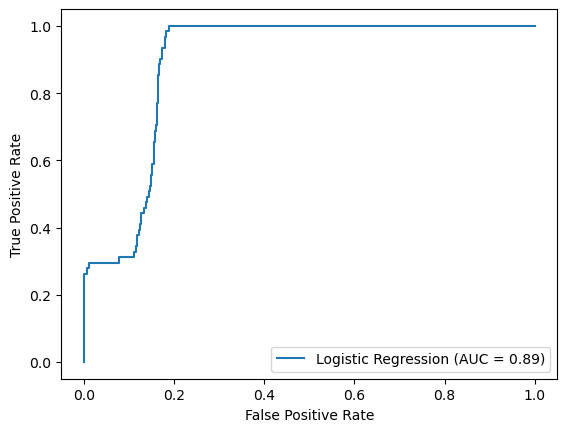

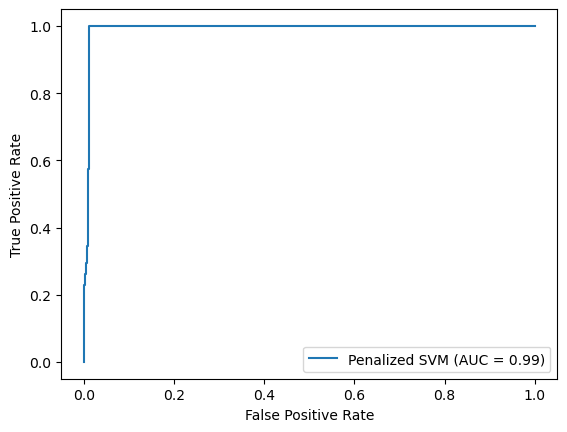

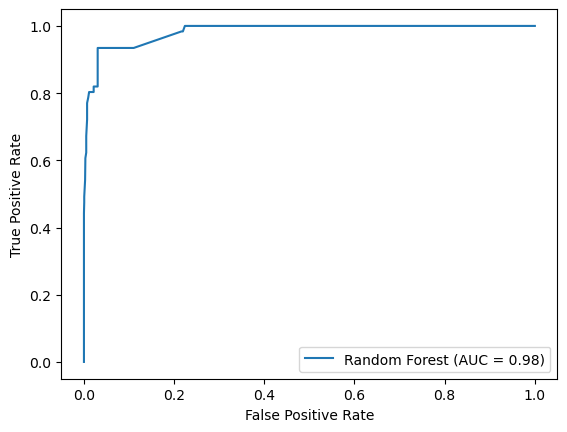

In [60]:
## Classification
for target_variable in target_variables_classification:
    for model_name, get_model in zip(model_names_classification, get_classification_models):
        print(model_name)
        model = get_model()
        model.fit(X_train[features], y_train[target_variable])
        positive_probs = [p[1] for p in model.predict_proba(X_test[features])]
        AUC_ROC = metrics.roc_auc_score(y_test[target_variable], positive_probs)
        fpr, tpr, thresholds = metrics.roc_curve(y_test[target_variable], positive_probs)
        roc_auc = metrics.auc(fpr, tpr)
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
        display.plot()
        predictions = model.predict(X_test[features])
        ACC = accuracy_score(y_test[target_variable], predictions)
        print("Test AUC_ROC:", AUC_ROC, "\nTest Accuracy:", ACC)

    total = y_test.shape[0]
    print("Baseline #1: naively always guess 0 (no recession)\nROC AUC:", 
        metrics.roc_auc_score(y_test[target_variable], np.zeros(total)), 
        "\nAccuracy:", accuracy_score(y_test[target_variable], np.zeros(total)))

    nums = np.zeros(total)
    nums[:total//10] = 1
    np.random.shuffle(nums)
    print("Baseline #2: naively guess 1 (recession) random 10% of the time:\nROC AUC:", 
        metrics.roc_auc_score(y_test[target_variable], nums), 
        "\nAccuracy:", accuracy_score(y_test[target_variable], nums))

    nums = np.zeros(total)
    for i in range(0, total//3650):
        start = randrange(total)
        for j in range(0, 365):
            nums[start + j] = 1
    print("Baseline #3: naively guess 1 (recession) occurs once for every 3650 days, but at a random point in time, and so that there is a recession 365 days onwards from that point in time\nROC AUC:", 
        metrics.roc_auc_score(y_test[target_variable], nums), 
        "\nAccuracy:", accuracy_score(y_test[target_variable], nums))
    

In [61]:
## Regression
for target_variable in target_variables_regression:
    print()
    print(target_variable)
    for model_name, get_model in zip(model_names_regression, get_regression_models):
        print()
        print(model_name)
        model = get_model()
        model.fit(X_train[features], y_train[target_variable])
        predictions = model.predict(X_test[features])
        R2 = r2_score(y_test[target_variable], predictions)
        print("Test R2:", R2)

    total = y_test.shape[0]
    print("\nBaseline #1: TODO")


GDP_rate

Linear Regression
Test R2: 0.11583003572584327

Baseline #1: TODO

GDP_abs

Linear Regression
Test R2: -58.484888317591626

Baseline #1: TODO
